# Homework Atlasova (part 2)
From the 1st HW some improvements were made.

## Introduction
We have a dataset of trending videos on Youtube in US.
We need to notice that in the initial dataset one video could have appeared several times since one video could be on trend several days.
Therefore, another table was created using SQLite with the data of videos on the first trending day and number of trending days. So now one video has only one row in the table with it's corresponding data on the first trending day (views, likes and etc
) and number of trending days. This would help us to do the analysis more precisely.

Below is the code on Python with notes and corresponding graphs for the analysis.

Let's first import libraries and make some configurations and data cleanup for further analysis.

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as sch

import datetime
import wordcloud
import json

In [2]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
pd.options.display.float_format = "{:.2f}".format

In [3]:
plot_colors = ["#d92027", "#ff9234", "#ffcd3c", "#35d0ba"]

In [4]:
# Create your connection.
cnx = sqlite3.connect('youtubeus.db')
df = pd.read_sql_query("SELECT * FROM video_first_trending_date", cnx)

## Univeriate analysis

Let's create some useful columns for further analysis and see how the dataset looks like.

In [5]:
df["description"] = df["description"].fillna(value="")
df["dislikes_likes_ratio"] = df["dislikes"].div(df["likes"])*100
df = df.replace(np.inf, 1)
df["dislikes_likes_ratio"] = df["dislikes_likes_ratio"].fillna(value=0)
df.head()

,video_id,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,first_trending_date,number_trending_days,dislikes_likes_ratio
0,-0CMnp02rNY,Mindy Kaling's Daughter Had the Perfect Reacti...,TheEllenShow,24,2018-06-04T13:00:00.000Z,ellen|ellen degeneres|the ellen show|ellentube...,475965,6531,172,271,https://i.ytimg.com/vi/-0CMnp02rNY/default.jpg,False,False,False,Ocean's 8 star Mindy Kaling dished on bringing...,18.06.06,6,2.63
1,-0NYY8cqdiQ,Megan Mullally Didn't Notice the Interesting P...,TheEllenShow,24,2018-01-29T14:00:39.000Z,megan mullally|megan|mullally|will and grace|k...,563746,4429,54,94,https://i.ytimg.com/vi/-0NYY8cqdiQ/default.jpg,False,False,False,Ellen and Megan Mullally have known each other...,18.01.02,1,1.22
2,-1Hm41N0dUs,Cast of Avengers: Infinity War Draws Their Cha...,Jimmy Kimmel Live,23,2018-04-27T07:30:02.000Z,jimmy|jimmy kimmel|jimmy kimmel live|late nigh...,2058516,41248,580,1484,https://i.ytimg.com/vi/-1Hm41N0dUs/default.jpg,False,False,False,"Benedict Cumberbatch, Don Cheadle, Elizabeth O...",18.01.05,3,1.41
3,-1yT-K3c6YI,YOUTUBER QUIZ + TRUTH OR DARE W/ THE MERRELL T...,Molly Burke,22,2017-11-28T18:30:43.000Z,youtube quiz|youtuber quiz|truth or dare|expos...,218227,7407,209,831,https://i.ytimg.com/vi/-1yT-K3c6YI/default.jpg,False,False,False,Check out the video we did on the Merrell Twin...,17.01.12,4,2.82
4,-2RVw2_QyxQ,2017 Champions Showdown: Day 3,Saint Louis Chess Club,27,2017-11-12T02:39:01.000Z,Chess|Saint Louis|Club,67429,438,23,23,https://i.ytimg.com/vi/-2RVw2_QyxQ/default.jpg,False,False,False,The Saint Louis Chess Club hosts a series of f...,17.14.11,3,5.25


Let'see how many rows/columns we have.

In [6]:
df.shape

(6351, 18)

Therefore, we have 6351 videos in our dataset which were on trend. Videos have data in 18 columns:
- video_id
- trending_date
title
channel_title
category_id
publish_time
tags
views
likes
10 dislikes
11 comment_count
12 thumbnail_link
13 comments_disabled
14 ratings_disabled
15 video_error_or_removed
16 description

### Outliers 

Let's make again some parts of the analysis but without outliers. 

Let's calculate D for numeric columns for further outliers detection.

In [7]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
D = Q3 - Q1
print(D)

views                  777317.50
likes                   25913.00
dislikes                  823.50
comment_count            2745.50
number_trending_days        5.00
dislikes_likes_ratio        5.97
dtype: float64


By using the formulas (Q3 +- 3 * D), let's identify severe outliers for views and likes.

In [ ]:
#print(Q1['views'])
df = df[(df['views'] > (Q1['views'] - 3 * D['views']))&(df['views'] < (Q3['views'] + 3 * D['views']))]
#df = df[(df['likes'] > (Q1['likes'] - 3 * D['likes']))&(df['likes'] < (Q3['likes'] + 3 * D['likes']))]
#df_new = df_new[(df_new['dislikes'] > (Q1['dislikes'] - 1.5 * D['dislikes']))&(df['dislikes'] < (Q3['dislikes'] + 1.5 * D['dislikes']))]
#df_new = df_new[(df_new['views'] > (Q1['views'] - 1.5 * D['views']))&(df['views'] < (Q3['views'] + 1.5 * D['views']))]


In [ ]:
from sklearn import preprocessing

x = df[['views','likes','dislikes']].values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df[['views','likes','dislikes']] = pd.DataFrame(x_scaled)
df.head()

### Describtion of numerical columns
Let's see statistical information about the numerical values.

In [ ]:
df.describe()

### Describtion of non-numerical columns
Let's see information about the non-numerical values.

In [ ]:
df.describe(include = ['O'])

## Bivariate Analysis

Let's see the scatter plots and histograms of all the variables.

In [ ]:
sns.pairplot(df)
plt.title('Pairplot for the Data', fontsize = 20)
plt.show()

Now let's look at the correlations coefficients.

In [ ]:
df.corr()

Let's make a heatmap of the correlation

In [ ]:
h_labels = [x.replace('_', ' ').title() for x in
            list(df.select_dtypes(include=['number', 'bool']).columns.values)]
fig, ax = plt.subplots(figsize=(10,6))
_ = sns.heatmap(df.corr(), annot=True, xticklabels=h_labels, yticklabels=h_labels, cmap=sns.cubehelix_palette(as_cmap=True), ax=ax)

We can see that likes/views are still correlated. Likes and comment count are not that correlated anymore. Correlation of the dislikes and dislikes/likes ratio is not relevant.

Let's have a closer look to the likes/views correlation via a scatter plot.

In [ ]:
fig, ax = plt.subplots()
_ = plt.scatter(x=df['views'], y=df['likes'], color=plot_colors[0], edgecolors="#000000", linewidths=0.5)
_ = ax.set(xlabel="views", ylabel="likes")

## Cluster Analysis

### Hierarchical Clustering
Let's make a hierarchical clustering for views.

In [ ]:
dendrogram = sch.dendrogram(sch.linkage(df[['views']], method = 'ward'))
plt.title('Dendrogam')
plt.xlabel('views')
plt.ylabel('Ecuclidean Distance')

Let's make a hierarchical clustering for likes.

In [ ]:
dendrogram = sch.dendrogram(sch.linkage(df[['likes']], method = 'ward'))
plt.title('Dendrogam')
plt.xlabel('likes')
plt.ylabel('Ecuclidean Distance')

### K-Means

Let's find clusters for the number of trending dates and dislikes/likes ratio values.

First, let's make the Elbow Method to find the number of optimal clusters.

In [ ]:
x = df[['number_trending_days','dislikes_likes_ratio']]
wcss = []
for i in range(1, 11):
    km = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    km.fit(x)
    wcss.append(km.inertia_)
    
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('number of clusters')
plt.ylabel('wcss')

Let's choose 3 as number of clusters.

In [ ]:
y_means = KMeans(n_clusters = 3, init = 'k-means++', max_iter=300, random_state = 0).fit_predict(x)
plt.scatter(x['number_trending_days'], x['dislikes_likes_ratio'], c = y_means, s = 50, alpha=0.5, edgecolors="#000000", linewidths=0.5)
plt.title('Clusters')
plt.xlabel('number_trending_days')
plt.ylabel('dislikes_likes_ratio')

We can say that:
- 1 cluster is "negative" videos which have a high dislikes/likes ratio and which are on trend not so many days,
- 2 cluster is "contreversial" videos which have a medium dislikes/likes ratio which can be on trend up to approximately 15 days,
- 3 cluster is "positive" videos which have a low dislikes/likes ratio which can have low and high number of trending days.

In [ ]:
x = df[['views','comment_count']]
wcss = []
for i in range(1, 11):
    km = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    km.fit(x)
    wcss.append(km.inertia_)
    
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('number of clusters')
plt.ylabel('wcss')

Let's choose 3 as number of clusters.

In [ ]:
y_means = KMeans(n_clusters = 3, init = 'k-means++', max_iter=300, random_state = 0).fit_predict(x)
plt.scatter(x['views'], x['comment_count'], c = y_means, s = 50, alpha=0.5, edgecolors="#000000", linewidths=0.5)
plt.title('Clusters')
plt.xlabel('views')
plt.ylabel('comment_count')

We can say that:
- 1 cluster is "negative" videos which have a high dislikes/likes ratio and which are on trend not so many days,
- 2 cluster is "contreversial" videos which have a medium dislikes/likes ratio which can be on trend up to approximately 15 days,
- 3 cluster is "positive" videos which have a low dislikes/likes ratio which can have low and high number of trending days.

In [ ]:
x = df[['views','likes']]
wcss = []
for i in range(1, 11):
    km = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    km.fit(x)
    wcss.append(km.inertia_)
    
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('number of clusters')
plt.ylabel('wcss')

Let's choose 3 as number of clusters.

In [ ]:
y_means = KMeans(n_clusters = 3, init = 'k-means++', max_iter=300, random_state = 0).fit_predict(x)
plt.scatter(x['views'], x['likes'], c = y_means, s = 50, alpha=0.5, edgecolors="#000000", linewidths=0.5)
plt.title('Clusters')
plt.xlabel('views')
plt.ylabel('likes')

We can say that:
- 1 cluster is "negative" videos which have a high dislikes/likes ratio and which are on trend not so many days,
- 2 cluster is "contreversial" videos which have a medium dislikes/likes ratio which can be on trend up to approximately 15 days,
- 3 cluster is "positive" videos which have a low dislikes/likes ratio which can have low and high number of trending days.

Let's find 3 dimensional clusters.

First, for views/likes/dislikes.

In [ ]:
x = df[['views', 'likes', 'dislikes']]

wcss = []
for i in range(1,11):
    model = KMeans(n_clusters = i,init = 'k-means++')
    model.fit(x)
    wcss.append(model.inertia_)
    
plt.plot(range(1,11), wcss)
plt.xlabel("number of clusters")
plt.ylabel("wcss")
plt.show()

Let's choose 3 as number of clusters.

In [ ]:
model = KMeans(n_clusters = 5, init = "k-means++", max_iter = 300, n_init = 10, random_state = 0)
y_clusters = model.fit_predict(x)

In [ ]:
sns.countplot(y_clusters)

In [ ]:
fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x['views'],x['likes'],x['dislikes'], s = 40 , c = y_clusters)
ax.set_xlabel('views')
ax.set_ylabel('likes')
ax.set_zlabel('dislikes')


Now for views/dislikes_likes_ratio/number_trending_days

In [ ]:
x = df[['views', 'dislikes_likes_ratio', 'number_trending_days']]

wcss = []
for i in range(1,11):
    model = KMeans(n_clusters = i,init = 'k-means++')
    model.fit(x)
    wcss.append(model.inertia_)
    
plt.plot(range(1,11), wcss)
plt.xlabel("number of clusters")
plt.ylabel("wcss")
plt.show()

Let's choose 5 as number of clusters.

In [ ]:
model = KMeans(n_clusters = 5, init = "k-means++", max_iter = 300, n_init = 10, random_state = 0)
y_clusters = model.fit_predict(x)

In [ ]:
sns.countplot(y_clusters)

In [ ]:
fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x['views'],x['dislikes_likes_ratio'],x['number_trending_days'], s = 40 , c = y_clusters)
ax.set_xlabel('views')
ax.set_ylabel('dislikes_likes_ratio')
ax.set_zlabel('number_trending_days')


In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle('Likes scatter plots', fontsize=16)
axs[0,0].scatter(df['views'], df['likes'], s = 30, color=plot_colors[0], edgecolors="#000000", linewidths=0.5)
axs[0,0].set(xlabel="views", ylabel="likes")
axs[0,0].set_title("df")

In [ ]:
#assigning number of plots
k = 3

fig, ax = plt.subplots(1, k, sharex='col', sharey='row')

_ = sns.distplot(df["views"], kde=False, color=plot_colors[3], hist_kws={'alpha': 1}, bins=np.linspace(0, 2.3e8, 47), ax = ax[0])
_ = ax[0].set(xlabel="views", ylabel="#", xticks=np.arange(0, 2.4e8, 1e7))
_ = ax[0].set_xlim(right=2.5e8)
_ = plt.xticks(rotation=90)
j = 1
    

In [ ]:
fig, ax = plt.subplots()
_ = sns.distplot(df["views"], kde=False, color=plot_colors[3],
                 hist_kws={'alpha': 1}, bins=np.linspace(0, 2.3e8, 47), ax=ax)
_ = ax.set(xlabel="views", ylabel="#", xticks=np.arange(0, 2.4e8, 1e7))
_ = ax.set_xlim(right=2.5e8)
_ = plt.xticks(rotation=90)

NameError: name 'PLOT_COLORS' is not defined

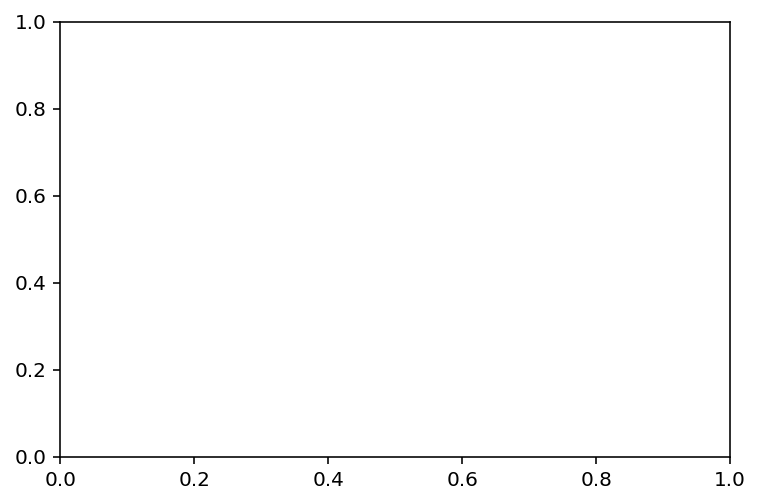

In [8]:
fig, ax = plt.subplots()
_ = sns.distplot(df[df["views"] < 25e6]["views"], kde=False,
                 color=PLOT_COLORS[4], hist_kws={'alpha': 1}, ax=ax)
_ = ax.set(xlabel="Views", ylabel="No. of videos")

In [ ]:
fig, ax = plt.subplots()
_ = ax.scatter(x=df['views'], y=df['category_id'], color=plot_colors[1], edgecolors="#000000", linewidths=0.5)
_ = ax.set(xlabel="Views", ylabel="category_id")

In [ ]:
fig, ax = plt.subplots()
_ = plt.scatter(x=df['views'], y=df['likes'], color=plot_colors[3], edgecolors="#000000", linewidths=0.5)
_ = ax.set(xlabel="Views", ylabel="Likes")

In [ ]:
x = df[['views', 'likes', 'dislikes']]
fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(111, projection='3d')
km = KMeans(n_clusters = 4, init = 'k-means++', max_iter=300, random_state = 0)
km.fit(x)
y_means = km.predict(x)

ax.scatter(x['views'],x['likes'],x['dislikes'], s = 40 , color = 'blue', label = "cluster 0")

#ax.scatter(x[[y_clusters == 0,0]],x[y_clusters == 0,1],x[y_clusters == 0,2], s = 40 , color = 'blue', label = "cluster 0")
#ax.scatter(x[y_clusters == 1,0],x[y_clusters == 1,1],x[y_clusters == 1,2], s = 40 , color = 'orange', label = "cluster 1")
#ax.scatter(x[y_clusters == 2,0],x[y_clusters == 2,1],x[y_clusters == 2,2], s = 40 , color = 'green', label = "cluster 2")
#ax.scatter(x[y_clusters == 3,0],x[y_clusters == 3,1],x[y_clusters == 3,2], s = 40 , color = '#D12B60', label = "cluster 3")
#ax.scatter(x[y_clusters == 4,0],x[y_clusters == 4,1],x[y_clusters == 4,2], s = 40 , color = 'purple', label = "cluster 4")
ax.set_xlabel('views')
ax.set_ylabel('likes')
ax.set_zlabel('dislikes')
ax.legend()
plt.show()

In [ ]:
x = df[['views', 'dislikes_likes_ratio', 'number_trending_days']].values
km = KMeans(n_clusters = 5, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
km.fit(x)
labels = km.labels_
centroids = km.cluster_centers_

In [ ]:
#data['labels'] =  labels
import plotly.graph_objs as go
trace1 = go.Scatter3d(
    x= df['views'],
    y= df['dislikes_likes_ratio'],
    z= df['number_trending_days'],
    mode='markers',
     marker=dict(
        size= 10,
        line=dict(
            width= 12
        ),
        opacity=0.8
     )
)
a = [trace1]

layout = go.Layout(
    title = 'Character vs Gender vs Alive or not',
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0  
    ),
    scene = dict(
            xaxis = dict(title  = 'Age'),
            yaxis = dict(title  = 'Spending Score'),
            zaxis = dict(title  = 'Annual Income')
        )
)

fig = go.Figure(data = a, layout = layout)
py.iplot(fig)

In [ ]:
x = df[['number_trending_days','dislikes_likes_ratio']]
x

In [ ]:
wcss = []
for i in range(1, 11):
    km = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    km.fit(x)
    wcss.append(km.inertia_)
    
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method', fontsize = 20)
plt.xlabel('No. of Clusters')
plt.ylabel('wcss')
plt.show()

In [ ]:
km = KMeans(n_clusters = 4, init = 'k-means++', max_iter=300, random_state = 0)
km.fit(x)
y_means = km.predict(x)
plt.scatter(x['views'], x['dislikes_likes_ratio'], c = y_means, s = 50, alpha=0.5)

In [ ]:
x = df[['likes','dislikes']]
x

In [ ]:
wcss = []
for i in range(1, 11):
    km = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    km.fit(x)
    wcss.append(km.inertia_)
    
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method', fontsize = 20)
plt.xlabel('No. of Clusters')
plt.ylabel('wcss')
plt.show()

In [ ]:
km = KMeans(n_clusters = 4, init = 'k-means++', max_iter=300, random_state = 0)
km.fit(x)
y_means = km.predict(x)
plt.scatter(x['likes'], x['dislikes'], c = y_means, s = 50, alpha=0.5)

In [ ]:
fig = plt.figure(figsize=(5, 5))

labels = km.predict(x)
centroids = km.cluster_centers_

plt.scatter(x['views'], x['number_trending_days'], s = 100, c = 'pink', label = 'miser')

plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:, 1], s = 50, c = 'blue' , label = 'centeroid')

In [ ]:

plt.scatter(x[y_means == 1, 0], x[y_means == 1, 1], s = 100, c = 'yellow', label = 'general')
plt.scatter(x[y_means == 2, 0], x[y_means == 2, 1], s = 100, c = 'cyan', label = 'target')
plt.scatter(x[y_means == 3, 0], x[y_means == 3, 1], s = 100, c = 'magenta', label = 'spendthrift')
plt.scatter(x[y_means == 4, 0], x[y_means == 4, 1], s = 100, c = 'orange', label = 'careful')
plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:, 1], s = 50, c = 'blue' , label = 'centeroid')

In [ ]:
pd.options.display.float_format = '{:.2f}'.format
sns.set(style="ticks")
plt.rc('figure', figsize=(8, 5), dpi=100)
plt.rc('axes', labelpad=20, facecolor="#ffffff", linewidth=0.4, grid=True, labelsize=14)
plt.rc('patch', linewidth=0)
plt.rc('xtick.major', width=0.2)
plt.rc('ytick.major', width=0.2)
plt.rc('grid', color='#9E9E9E', linewidth=0.4)
plt.rc('font', family='Arial', weight='400', size=10)
plt.rc('text', color='#282828')
plt.rc('savefig', pad_inches=0.3, dpi=300)